In [ ]:
# results = model.train(data='VisDrone.yaml', epochs=100, imgsz=640, batch=8)
# results
# model.names.values()

In [7]:
import os
from PIL import Image, ImageDraw
import numpy as np
from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator
import cv2
import matplotlib.pyplot as plt

In [5]:
image_folder_path = r"D:\etudes\Ynov\Deep Learning\fil-rouge\projet-fil-rouge-dl\sandboxes\datasets\VisDrone\VisDrone2019-DET-test-dev\images\\"
# image_path = image_folder_path + "9999947_00000_d_0000004.jpg"
image_path = image_folder_path + "9999938_00000_d_0000212.jpg"
image = Image.open(image_path)
vehicles = ['bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat']

In [1]:
# Load the YOLO model
path_to_weights = 'runs/detect/train/weights/best.pt'

# model = YOLO('yolov8n.pt')
model = YOLO(path_to_weights)

# Load the image you want to test

# Perform object detection on the image
results = model.predict(image, iou=0.2, conf=0.3)

# r = results[0].plot()
# cv2.imshow('', r)
results[0].show()



0: 480x640 2 pedestrians, 3 peoples, 8 cars, 1 van, 1 bus, 20 motors, 135.0ms
Speed: 847.6ms preprocess, 135.0ms inference, 1336.6ms postprocess per image at shape (1, 3, 480, 640)


In [8]:

# Create a folder to save extracted objects
extracted_folder = 'extracted'
os.makedirs(extracted_folder, exist_ok=True)

# Convert the PIL image to a NumPy array
image_np = np.array(image)

# Draw bounding boxes on the image
annotator = Annotator(image_np, font_size=0.1)
for i, r in enumerate(results):
    boxes = r.boxes
    for j, box in enumerate(boxes):
        # Extract coordinates from the Tensor box
        b = box.xyxy[0].cpu().numpy()  # Convert Tensor to NumPy array
        b = b.astype(int)  # Convert to integer
        
        c = box.cls
        confidence = box.conf.to().cpu().numpy()[0]
        print (confidence)
        annotator.box_label(b, model.names[int(c)] + ' '+ str(round(confidence, 2)))
        
        # Extract object and save it
        extracted_image = image.crop((b[0], b[1], b[2], b[3]))
        extracted_image.save(os.path.join(extracted_folder, f'extracted_{i}_{j}.jpg'))

# Get the image with bounding boxes
img_prediction = annotator.result()

# Display the image with bounding boxes
Image.fromarray(img_prediction).show()


0.78694665
0.7866431
0.7818771
0.7730399
0.7710208
0.7685945
0.73559195
0.7287111
0.7216296
0.7211936
0.7201344
0.71211
0.6809487
0.67213416
0.6649067
0.6502383
0.6482765
0.5940516
0.58780193
0.5834817
0.58285606
0.5684958
0.56838983
0.56515086
0.5583956
0.5555118
0.54451615
0.52808475
0.4949529
0.486444
0.48261702
0.4792959
0.47744972
0.47063348
0.46719408
0.46490487
0.46479288
0.455806
0.45540977
0.4497223
0.44852132
0.4445231
0.43230492
0.42526466
0.42139533
0.40838203
0.40524644
0.3976074
0.369797
0.35747012
0.3569261
0.3454019
0.33904243
0.33545607
0.33498034
0.3307785
0.31810686
0.30806988
0.30593866
0.30469063
0.30062887
0.30061883


### yolov8n_obb

In [3]:
yolov8n_obb = YOLO('yolov8n-obb.pt')  # load an official model

In [13]:
results_obb = yolov8n_obb.predict(image, iou=0.5, conf=0.3)[0]
results_obb.show()

xyxys = results_obb.obb.xyxy
xyxyxyxys = results_obb.obb.xyxyxyxy
orig_img = results_obb.orig_img


0: 576x1024 122.0ms
Speed: 12.0ms preprocess, 122.0ms inference, 13.0ms postprocess per image at shape (1, 3, 576, 1024)


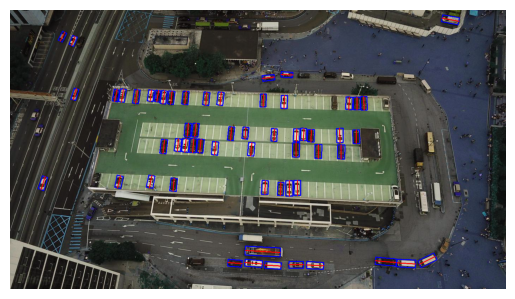

In [15]:
# for j, xyxy in enumerate(xyxys):
	# cv2.rectangle(orig_img, (int(xyxy[0]), int(xyxy[1])), (int(xyxy[2]), int(xyxy[3])), (0, 255, 0), 2)

for j, xyxyxyxy in enumerate(xyxyxyxys):
    coords = xyxyxyxy.detach().cpu().numpy()
    points = coords.reshape((-1, 1, 2)).astype(np.int32)  # Convert tensor to numpy array
    cv2.polylines(orig_img, [points], isClosed=True, color=(0, 0, 255), thickness=2)
    
    longest_side_index = np.argmax(np.linalg.norm(coords[1:] - coords[:-1], axis=1))
    midpoint = (coords[longest_side_index] + coords[longest_side_index + 2]) / 2
    direction_vector = coords[longest_side_index + 1] - coords[longest_side_index]

    # Calculate the endpoints for the line parallel to the longest side and passing through the midpoint
    line_length = np.linalg.norm(direction_vector)
    line_endpoint1 = midpoint - direction_vector / 2
    line_endpoint2 = midpoint + direction_vector / 2

	# Draw the line on the image
    cv2.line(orig_img, (int(line_endpoint1[0]), int(line_endpoint1[1])), (int(line_endpoint2[0]), int(line_endpoint2[1])), (255, 0, 0), 2)

plt.axis('off')
plt.imshow(orig_img)
plt.show()
		

### Live

In [10]:
video ='https://hd-auth.skylinewebcams.com/live.m3u8?a=k8cto71db7esp089jstmtu0ri7'

HEIGHT = 640
WIDTH = 480

cap = cv2.VideoCapture(video)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, WIDTH)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, HEIGHT)

model = yolov8n_obb

# Loop through the video frames
while cap.isOpened():
    # Read a frame from the video
    success, frame = cap.read()

    if success:
        # Run YOLOv8 tracking on the frame, persisting tracks between frames
        results = model.predict(frame, iou=0.8, retina_masks=True)[0]
        # Visualize the results on the frame
        orig_img = results.orig_img
        xyxyxyxys = results.obb.xyxyxyxy

        for j, xyxyxyxy in enumerate(xyxyxyxys):
            coords = xyxyxyxy.detach().cpu().numpy()
            points = coords.reshape((-1, 1, 2)).astype(np.int32)  # Convert tensor to numpy array
            cv2.polylines(orig_img, [points], isClosed=True, color=(0, 0, 255), thickness=2)

            longest_side_index = np.argmax(np.linalg.norm(coords[1:] - coords[:-1], axis=1))
            midpoint = (coords[longest_side_index] + coords[longest_side_index + 2]) / 2
            direction_vector = coords[longest_side_index + 1] - coords[longest_side_index]

            # Calculate the endpoints for the line parallel to the longest side and passing through the midpoint
            line_length = np.linalg.norm(direction_vector)
            line_endpoint1 = midpoint - direction_vector / 2
            line_endpoint2 = midpoint + direction_vector / 2

            # Draw the line on the image
            cv2.line(orig_img, (int(line_endpoint1[0]), int(line_endpoint1[1])), (int(line_endpoint2[0]), int(line_endpoint2[1])), (255, 0, 0), 2)

        # Display the annotated frame
        cv2.imshow("YOLOv8 Tracking", orig_img)

        # Break the loop if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
    else:
        # Break the loop if the end of the video is reached
        break

# Release the video capture object and close the display window
cap.release()
cv2.destroyAllWindows()



0: 576x1024 118.5ms
Speed: 12.4ms preprocess, 118.5ms inference, 8.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 95.0ms
Speed: 18.0ms preprocess, 95.0ms inference, 4.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 93.0ms
Speed: 14.0ms preprocess, 93.0ms inference, 9.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 68.0ms
Speed: 14.0ms preprocess, 68.0ms inference, 4.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 13.0ms
Speed: 15.0ms preprocess, 13.0ms inference, 4.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 12.0ms
Speed: 9.0ms preprocess, 12.0ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 15.0ms
Speed: 7.0ms preprocess, 15.0ms inference, 6.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 12.0ms
Speed: 7.0ms preprocess, 12.0ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 13.0ms
Speed: 8.0ms preprocess, 13.0

### Licence plate

In [6]:
image_folder_path = r"./eswann/"
# image_path = image_folder_path + "9999947_00000_d_0000004.jpg"
image_path = image_folder_path + "plates3.jpg"
image = Image.open(image_path)

In [7]:
path_to_weights = 'runs/detect/train/weights/best.pt'
yolo_custom = YOLO(path_to_weights)
license_plate_detector = YOLO('license_plate_detector.pt')

In [8]:
results = model.predict(image, iou=0.2, conf=0.3)
results[0].show()

NameError: name 'model' is not defined

In [9]:
def plot_image(orig_img, xyxy):
    
    cv2.rectangle(orig_img, (int(xyxy[0]), int(xyxy[1])), (int(xyxy[2]), int(xyxy[3])), (0, 255, 0), 1)
    plt.axis('off')
    plt.imshow(orig_img[int(xyxy[1]-10):int(xyxy[3]+10), int(xyxy[0]-10):int(xyxy[2]+10)])
    plt.show()

0: 448x640 1 license_plate, 62.8ms
Speed: 5.0ms preprocess, 62.8ms inference, 2.6ms postprocess per image at shape (1, 3, 448, 640)
xyxy
[[        147       156.5      228.95      186.15]]


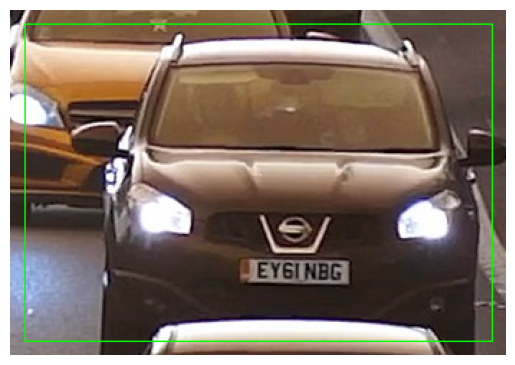

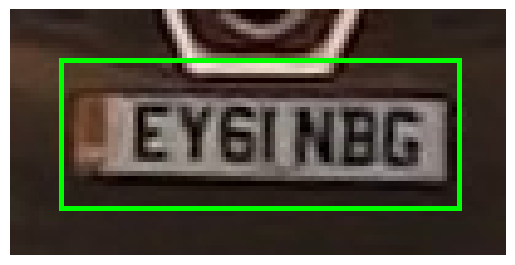

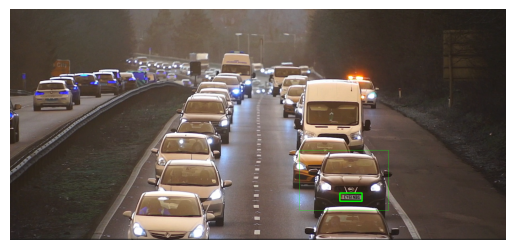


0: 640x576 (no detections), 9.0ms
Speed: 3.0ms preprocess, 9.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)
xyxy
[]

0: 256x640 (no detections), 10.0ms
Speed: 1.0ms preprocess, 10.0ms inference, 2.0ms postprocess per image at shape (1, 3, 256, 640)
xyxy
[]


In [200]:
orig_img = results[0].orig_img

for i, r in enumerate(results):
	boxes = r.boxes
	# boxes = [r.boxes[0]]
	for j, box in enumerate(boxes):
		if model.names[int(box.cls)] in vehicles:
			xyxy = box.xyxy[0]

			b = xyxy.cpu().numpy()  # Convert Tensor to NumPy array
			b = b.astype(int)  # Convert to integer
			extracted_image = image.crop((b[0], b[1], b[2], b[3]))

			license_plates = license_plate_detector(extracted_image)[0]
			lp_orig_img = license_plates.orig_img
			lp_xyxy = license_plates.boxes.xyxy.to().cpu().numpy()
			print('xyxy')
			print(lp_xyxy)
			if lp_xyxy.size != 0:
				plot_image(orig_img, xyxy)
				plot_image(lp_orig_img, lp_xyxy[0])

				cv2.rectangle(orig_img, (int(xyxy[0])+int(lp_xyxy[0][0]), int(xyxy[1])+int(lp_xyxy[0][1])), (int(xyxy[0])+int(lp_xyxy[0][2]), int(xyxy[1])+int(lp_xyxy[0][3])), (0, 255, 0), 3)
				plt.imshow(orig_img)
				plt.axis('off')
				plt.show()


### Licence plate LIVE

In [11]:
import easyocr

def calc_plate_coord(xyxy, lp_xyxy):
	return (int(xyxy[0])+int(lp_xyxy[0]), int(xyxy[1])+int(lp_xyxy[1])), (int(xyxy[0])+int(lp_xyxy[2]), int(xyxy[1])+int(lp_xyxy[3]))

def read_license_plate(license_plate_crop):
	reader = easyocr.Reader(['en'], gpu=False)
	detections = reader.readtext(license_plate_crop)

	for detection in detections:
		_, text, score = detection # bbox, text, score
		text = text.upper().replace(' ', '')
		return text, score
	return None, None


In [14]:

video ='./eswann/sample.mp4'

HEIGHT = round(1080*2/3)
WIDTH = round(1920*2/3)

cap = cv2.VideoCapture(video)
# cap.set(cv2.CAP_PROP_FRAME_WIDTH, WIDTH)
# cap.set(cv2.CAP_PROP_FRAME_HEIGHT, HEIGHT)

model = yolo_custom

# Loop through the video frames
while cap.isOpened():
	# Read a frame from the video
	success, frame = cap.read()
	frame = cv2.resize(frame, (WIDTH, HEIGHT))

	if success:
		# Run YOLOv8 tracking on the frame, persisting tracks between frames
		results = model.predict(frame, iou=0.75, conf=0.6, retina_masks=True)[0]
		# Visualize the results on the frame
		orig_img = results.orig_img

		# for j, box in enumerate(results.boxes):
		# 	if model.names[int(box.cls)] in vehicles:
		# 		xyxy = box.xyxy[0]
		# 		# cv2.rectangle(orig_img, (int(xyxy[0]), int(xyxy[1])), (int(xyxy[2]), int(xyxy[3])), (0, 255, 0), 2)

		# 		b = xyxy.cpu().numpy()  # Convert Tensor to NumPy array
		# 		b = b.astype(int)  # Convert to integer
		# 		extracted_image = orig_img[b[1]:b[3], b[0]:b[2]]

		# 		license_plates = license_plate_detector(extracted_image, iou=0.1)[0]
		# 		lp_orig_img = license_plates.orig_img
		# 		lp_xyxy = license_plates.boxes.xyxy.to().cpu().numpy()

		# 		if lp_xyxy.size != 0:
		# 			plate_cord = calc_plate_coord(xyxy, lp_xyxy[0])
		# 			cv2.rectangle(orig_img, plate_cord[0], plate_cord[1], (0, 0, 255), 2)

		for j, box in enumerate(results.boxes):
			if model.names[int(box.cls)] in vehicles:
				xyxy = box.xyxy[0]
				# cv2.rectangle(orig_img, (int(xyxy[0]), int(xyxy[1])), (int(xyxy[2]), int(xyxy[3])), (0, 255, 0), 2)

				b = xyxy.cpu().numpy()  # Convert Tensor to NumPy array
				b = b.astype(int)  # Convert to integer
				extracted_image = orig_img[b[1]:b[3], b[0]:b[2]]

				license_plates = license_plate_detector(extracted_image, iou=0.1)[0]
				lp_orig_img = license_plates.orig_img
				lp_xyxy = license_plates.boxes.xyxy.to().cpu().numpy()

				if lp_xyxy.size != 0:
					plate_cord = calc_plate_coord(xyxy, lp_xyxy[0])
					cv2.rectangle(orig_img, plate_cord[0], plate_cord[1], (0, 0, 255), 2)

					# crop license plate
					((pc_x1, pc_y1), (pc_x2, pc_y2)) = plate_cord
					license_plate_crop = frame[int(pc_y1):int(pc_y2), int(pc_x1): int(pc_x2), :]

					# process license plate
					license_plate_crop_gray = cv2.cvtColor(license_plate_crop, cv2.COLOR_BGR2GRAY)
					_, license_plate_crop_thresh = cv2.threshold(license_plate_crop_gray, 64, 255, cv2.THRESH_BINARY_INV)

					# read license plate number
					license_plate_text, license_plate_text_score = read_license_plate(license_plate_crop_thresh)
					cv2.putText(orig_img, license_plate_text, plate_cord[0], cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

		# Display the annotated frame
		cv2.imshow("YOLOv8 Tracking", orig_img)

		# Break the loop if 'q' is pressed
		if cv2.waitKey(1) & 0xFF == ord("q"):
			break
	else:
		# Break the loop if the end of the video is reached
		break

# Release the video capture object and close the display window
cap.release()
cv2.destroyAllWindows()



0: 384x640 6 cars, 1336.6ms
Speed: 479.3ms preprocess, 1336.6ms inference, 525.5ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 1 license_plate, 62.0ms
Speed: 5.0ms preprocess, 62.0ms inference, 15.0ms postprocess per image at shape (1, 3, 480, 640)


Using CPU. Note: This module is much faster with a GPU.


error: OpenCV(4.9.0) :-1: error: (-5:Bad argument) in function 'putText'
> Overload resolution failed:
>  - img is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'img'


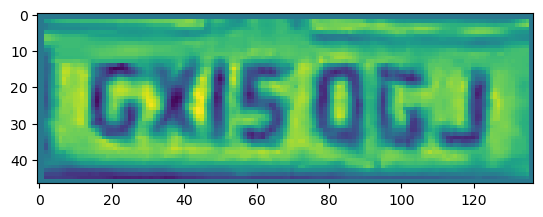

In [90]:

plt.imshow(license_plate_crop2)

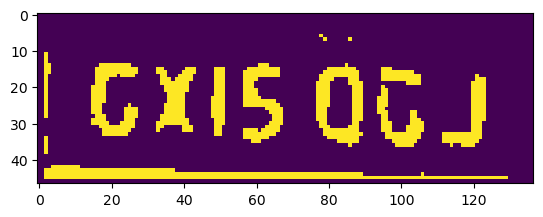

In [91]:
plt.imshow(cv2.threshold(license_plate_crop_gray2, 75, 255, cv2.THRESH_BINARY_INV)[1])

# Pour léa

In [94]:
from ultralytics import YOLO
import cv2
import easyocr
# Necessite Pillow==9.5.0

def calc_plate_coord(xyxy, lp_xyxy):
	return (int(xyxy[0])+int(lp_xyxy[0]), int(xyxy[1])+int(lp_xyxy[1])), (int(xyxy[0])+int(lp_xyxy[2]), int(xyxy[1])+int(lp_xyxy[3]))

def read_license_plate(license_plate_crop):
	reader = easyocr.Reader(['en'], gpu=False)
	detections = reader.readtext(license_plate_crop)

	for detection in detections:
		_, text, score = detection # bbox, text, score
		text = text.upper().replace(' ', '')
		return text, score
	return None, None

path_to_weights = 'runs/detect/train/weights/best.pt'
yolo_custom = YOLO(path_to_weights)
license_plate_detector = YOLO('license_plate_detector.pt')
vehicles = ['car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat']

video ='./eswann/sample.mp4'

HEIGHT = round(1080)
WIDTH = round(1920)
plates_frame_lag = 3 # Chercher les plates toutes les X frames 

cap = cv2.VideoCapture(video)
# cap.set(cv2.CAP_PROP_FRAME_WIDTH, WIDTH)
# cap.set(cv2.CAP_PROP_FRAME_HEIGHT, HEIGHT)

model = yolo_custom


saved_plates_cord = []
saved_lps_text = []
frame_id = -1
# Loop through the video frames
while cap.isOpened():
	if frame_id > 99999:
		frame_id = 0
	frame_id += 1
	must_read_plate = frame_id % plates_frame_lag == 0
	# Read a frame from the video
	success, frame = cap.read()
	# frame = cv2.resize(frame, (WIDTH, HEIGHT))

	if success:
		# Run YOLOv8 tracking on the frame, persisting tracks between frames
		results = model.predict(frame, iou=0.75, conf=0.6, retina_masks=True)[0]
		# Visualize the results on the frame
		orig_img = results.orig_img
		
		if not must_read_plate:
			for saved_plate_cord in saved_plates_cord:
				cv2.rectangle(orig_img, saved_plate_cord[0], saved_plate_cord[1], (0, 0, 255), 2)
			for saved_lp_text in saved_lps_text:
				cv2.putText(orig_img, saved_lp_text[0], saved_lp_text[1], cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
		else:
			saved_plates_cord = []
			saved_lps_text = []

		for j, box in enumerate(results.boxes):
			if model.names[int(box.cls)] in vehicles:
				if must_read_plate:
					xyxy = box.xyxy[0]
					# cv2.rectangle(orig_img, (int(xyxy[0]), int(xyxy[1])), (int(xyxy[2]), int(xyxy[3])), (0, 255, 0), 2)

					b = xyxy.cpu().numpy()  # Convert Tensor to NumPy array
					b = b.astype(int)  # Convert to integer
					extracted_image = orig_img[b[1]:b[3], b[0]:b[2]]

					license_plates = license_plate_detector(extracted_image, iou=0.1)[0]
					lp_orig_img = license_plates.orig_img
					lp_xyxy = license_plates.boxes.xyxy.to().cpu().numpy()

					if lp_xyxy.size != 0:
						plate_cord = calc_plate_coord(xyxy, lp_xyxy[0])
						cv2.rectangle(orig_img, plate_cord[0], plate_cord[1], (0, 0, 255), 2)
						saved_plates_cord.append(plate_cord)

						# Ajoute les numéros de plaque
						# # crop license plate
						# ((pc_x1, pc_y1), (pc_x2, pc_y2)) = plate_cord
						# license_plate_crop = frame[int(pc_y1):int(pc_y2), int(pc_x1): int(pc_x2), :]

						# # process license plate
						# license_plate_crop_gray = cv2.cvtColor(license_plate_crop, cv2.COLOR_BGR2GRAY)
						# _, license_plate_crop_thresh = cv2.threshold(license_plate_crop_gray, 75, 255, cv2.THRESH_BINARY_INV)

						# # read license plate number
						# license_plate_text, license_plate_text_score = read_license_plate(license_plate_crop_thresh)
						# if license_plate_text is not None:
						# 	license_plate_crop2 = license_plate_crop
						# 	license_plate_crop_gray2 = license_plate_crop_gray
						# 	lp_text = license_plate_text + ' ' + str(round(license_plate_text_score, 3))
						# 	saved_lps_text.append((lp_text, plate_cord[0]))
						# 	cv2.putText(orig_img, lp_text, plate_cord[0], cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

		# Display the annotated frame
		orig_img = cv2.resize(orig_img, (WIDTH, HEIGHT))
		cv2.imshow("YOLOv8 Tracking", orig_img)

		# Break the loop if 'q' is pressed
		if cv2.waitKey(1) & 0xFF == ord("q"):
			break
	else:
		# Break the loop if the end of the video is reached
		break

# Release the video capture object and close the display window
cap.release()
cv2.destroyAllWindows()



0: 384x640 4 cars, 18.0ms
Speed: 5.0ms preprocess, 18.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 (no detections), 17.0ms
Speed: 4.0ms preprocess, 17.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x576 1 license_plate, 19.0ms
Speed: 6.0ms preprocess, 19.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 576)

0: 480x640 1 license_plate, 16.0ms
Speed: 3.0ms preprocess, 16.0ms inference, 4.0ms postprocess per image at shape (1, 3, 480, 640)

0: 512x640 (no detections), 24.0ms
Speed: 2.0ms preprocess, 24.0ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 640)

0: 384x640 4 cars, 43.0ms
Speed: 6.0ms preprocess, 43.0ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 van, 23.0ms
Speed: 4.0ms preprocess, 23.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 21.0ms
Speed: 10.0ms preprocess, 21.0ms inference, 3.0ms postprocess 